# Arbol de Decisión: Clasificación

### Paquetes utilizados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from kneed import KneeLocator
from cleaning import CleaningData #propia
from sklearn.cluster import KMeans

#BOpt
from skopt import BayesSearchCV #después lo hacemos con RandomSearchCv

### Carga de datos pre-procesados

In [2]:
# Cargo dataset original y hago un poco de pre processing, luego vamos a tener que cambiarlo para
# incorporar tanto Pre-processing y Feature Engineering. 

nocols = ['Unnamed: 0', 'Unnamed: 0.1']

gitlfs_url = "https://github.com/Ignacio-Ibarra/tpAA/blob/main/data/cabaventa.csv"

try: 
    cols = list(pd.read_csv(gitlfs_url, nrows = 1))
    raw_df = pd.read_csv(gitlfs_url, usecols =[col for col in cols if col not in nocols])
except: 
    cols =  list(pd.read_csv("./data/cabaventa.csv", nrows =1))
    raw_df = pd.read_csv("./data/cabaventa.csv", usecols =[col for col in cols if col not in nocols])
raw_df.shape

#borro columnas, borro nulos de un saque, saco "ARS". Me queda un dataset herrrrmoso. 
cleaned = CleaningData(data=raw_df)
cols_to_drop = [#'Unnamed: 0.1', 'Unnamed: 0', #columnas que vinieron mal en la bajada
                'operation_type', #todos son 'venta'
                'l1', # todos son 'Argentina'
                'l2', # todos son "Capital Federal"
                'ad_type', #todas las filas iguales 
                'l4', #todas las filas nulas preferible el dato de lat y long
                'l5', #columna con todas las filas nulas
                'l6', #columna con todas las filas nulas
                'created_on', #la columna created_on es igual a la columna start_date
               ]
data = cleaned.drop_columns(columns=cols_to_drop)
data = data.dropna()
data = data[data.currency!="ARS"].reset_index(drop=True)
data.shape

Cleaning columns with no valuable information...



(41315, 17)

## Categorización de la variable precio

El proceso de *binning* de la variable precio se realizó de manera no supervisada, utilizando el algoritmo de k-medias para encontrar las particiones más eficientes, entendiendo la eficiencia como la creación de grupos en los cuales la suma cuadrática de las distancias de cada valor al *centroide* del grupo sea mínima. 

Ejemplo: con una variable que toma valores: 1, 2, 3, 20, 21, 22, 25, 26, 30, 32, 50, 51, 52, 53, 100, 101 si se usaran métodos convencionales como la división en cuartiles quedarían los grupos conformados de la siguiente manera: 

+ 1° grupo: 1,2,3,20 
+ 2° grupo 21, 22, 25, 26  
+ 3° grupo 30, 32, 50, 51
+ 4° grupo 52, 53, 100, 101

Lo que generaría grupos balanceados, pero también compuesto por muestras muy heterogéneas.
En cambio con k-medias, la separación óptima serían 5 grupos: 

+ 1° grupo: 1,2,3
+ 2° grupo 20, 21, 22, 25, 26  
+ 3° grupo 30, 32 
+ 4° grupo 50, 51, 52, 53 
+ 5° grupo 100, 101

En este caso, los grupos quedarían más distinguidos, internamente más homogéneos, aunque se generan muestras desbalanceadas. 
**Nota**: este método de *binning* no constituye una práctica de *hardcoding* de la variable respuesta dado que se ha realizado de manera univariada, sin agregar otros atributos del dataset. 

### Transformación Logarítmica

Previo a la categorización de la variable precio, se realizó una tranformación logarítimica de la variable para quitar el sesgo y hacer más eficiente la separación en intervalos.

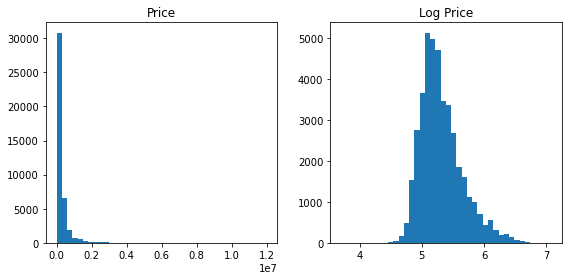

In [3]:
fig, axs = plt.subplots(figsize=(8,4), ncols = 2)

axs[0].hist(data.price, bins=40)
axs[0].set_title("Price")

axs[1].hist(np.log10(data.price+1), bins=40)
axs[1].set_title("Log Price")
plt.tight_layout()
plt.savefig("./img/transf-log.png", dpi=200, facecolor="white")
#plt.show()

### K-Medias

El método consiste en definir un hyper-parámetro k, el cual es un 'int', y el algortimo va armando los k-grupos que minimizan la suma de las distancias cuadráticas de cada instancia al centroide (vector de medias del grupo). Dado que aquí se está aplicando el método para un vector de 1 dimensión, es decir se utiliza de modo univariado, el algoritmo lo que hará es separar la variable log-price en k-grupos de modo que se minimice la suma de las distancias cuadráticas de cada valor a la media de su grupo. El punto consiste en encontrar el parámetro k óptimo de modo tal de que se encuentre de manera no supervisada los grupos en los que "naturalmente" está dividida la variable. Para encontrar el parámetro óptimo una de las formas habituales es la solución gráfica del "codo". En un gráfico de dos dimensiones, en el eje horizontal el valor de k y en el eje vertical la suma de las distancias cuadráticas, el valor de k óptimo es allí donde la curva presenta un "codo". 

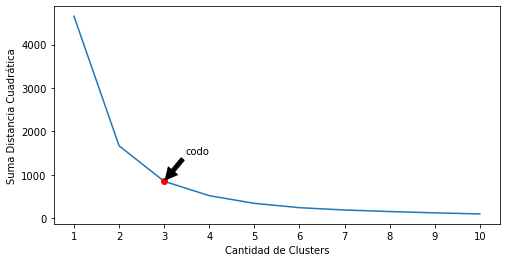

In [4]:
var_data = np.log10(data.price+1).to_numpy().reshape(-1, 1)

kmeans_kwargs = {
  "init": "random",
  "n_init": 10,
  "max_iter": 300,
  "random_state": 42,
  }

max_clusters = 10

sse = []
for k in range(1, max_clusters+1):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(var_data)
  sse.append(kmeans.inertia_)

kl = KneeLocator(
      range(1, max_clusters+1), sse, curve="convex", direction="decreasing"
                  )
nclust = kl.elbow

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(range(1, max_clusters+1), sse)
ax.plot(nclust,sse[nclust-1], 'ro')
ax.annotate('codo', xy=(3, sse[nclust-1]),  xycoords='data',
            xytext=(4, sse[nclust-2]), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top',
            )
ax.set_xticks(range(1, max_clusters+1))
ax.set_xlabel("Cantidad de Clusters")
ax.set_ylabel("Suma Distancia Cuadrática")
plt.savefig("./img/codo.png", dpi=200, facecolor="white")

Dado que el algortimo selecciona como óptima una separación en 3 grupos, entonces se procede a categorizar la variable log-price en tres grupos, los cuales presentan las siguientes características. 

In [5]:
kl = KneeLocator(
      range(1, max_clusters+1), sse, curve="convex", direction="decreasing"
                  )
nclust = kl.elbow

kmeans = KMeans(
     init="random",
     n_clusters=nclust,
     n_init=10,
     max_iter=300,
     random_state=42)
kmeans.fit(var_data)
data['labels'] = kmeans.labels_

def percentage(x):
    return "{:.2%}".format(x.count()/len(data))

tabla = data.groupby('labels').agg({'price':['min','max',percentage]}).reset_index()
tabla.columns = ['Clases','Min','Max','Porcentaje']
tabla.set_index("Clases")
#print(tabla.to_latex())

,Min,Max,Porcentaje
Clases,,,
0,5000.0,171700.0,47.65%
1,171800.0,485000.0,39.04%
2,485979.0,12000000.0,13.31%


Tal como se observa, la categorización deriva en la generación de clases desbalanceadas. Este método solo genera clases balanceadas en caso de que la variable se distribuya de manera uniforme. 

In [6]:
chi = np.random.chisquare(2,10000).reshape(-1,1)
norm = np.random.normal(0, 1, 10000).reshape(-1, 1)
unif = np.random.uniform(-1,1,10000).reshape(-1, 1)

km0 = KMeans(
     init="random",
     n_clusters=3,
     n_init=10,
     max_iter=300,
     random_state=42)

km1 = KMeans(
     init="random",
     n_clusters=3,
     n_init=10,
     max_iter=300,
     random_state=42)

km2 = KMeans(
     init="random",
     n_clusters=3,
     n_init=10,
     max_iter=300,
     random_state=42)

chisquare =  pd.Series(km0.fit_predict(chi)).value_counts(normalize=True)
normal = pd.Series(km1.fit_predict(norm)).value_counts(normalize=True)
uniforme = pd.Series(km2.fit_predict(unif)).value_counts(normalize=True)

tabla = pd.concat([chisquare, normal, uniforme], axis=1).reset_index()
tabla.columns = ["Clases","PesosChi","PesosNormal", "PesosUniforme"]
tabla.set_index("Clases")
#print(tabla.to_latex())


,PesosChi,PesosNormal,PesosUniforme
Clases,,,
1,0.6451,0.2738,0.3331
0,0.2841,0.4507,0.3379
2,0.0708,0.2755,0.3290


### 

## Modelo

### Generamos el DataSet que usaremos para entrenar y testear el modelo:

In [7]:
num_vars = ['lat', 'lon', 'rooms', 
            'bedrooms','bathrooms', 'surface_total', 
            'surface_covered']#estas son las que usamos por ahora.
cat_vars = ['l3', 'property_type']
labels = ['labels']

enc = OneHotEncoder(handle_unknown='error', drop="first") 
x_cat = enc.fit_transform(data[cat_vars])

cols = enc.get_feature_names(cat_vars)
cat_df = pd.DataFrame(x_cat.toarray(), columns = cols)
num_df = data[num_vars]
scaler = StandardScaler()
scaled = scaler.fit_transform(num_df)
num_df = pd.DataFrame(scaled, columns = num_vars)
#enc_labs  = OneHotEncoder(handle_unknown='error', drop="first") 
labels = pd.get_dummies(data.labels).to_numpy()

X = pd.concat([data.id, num_df, cat_df], axis=1)

X.shape

c:\Users\leandro.morinigo\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(41315, 72)

### Generando el Arbol Simple (punto 5)

In [11]:
X1 = X.iloc[:,1:]
Y1 = labels
seed1 = 42

# Separar en conjunto de entrenamiento y conjunto de prueba
x1_train, x1_test, y1_train, y1_test = train_test_split(X1, Y1, test_size=0.2, random_state= seed1 , stratify=Y1)

# Creamos el arbol simple:
max_depth = 4
arbol_simple = DecisionTreeClassifier(max_depth = max_depth)

# Entrenamos el modelo:
arbol_simple.fit(x1_train, y1_train)

# Predecimos:
y1_pred = arbol_simple.predict(x1_test)

### Evaluamos el Arbol generado

In [32]:
# Creamos la matriz de confusion:
from sklearn.metrics import confusion_matrix
import seaborn as sns

nombres = ['Baja', 'Media', 'Alta']

matriz = confusion_matrix(y1_test.argmax(axis=1), y1_pred.argmax(axis=1))
df_mc = pd.DataFrame(matriz, index=nombres, columns=nombres)
df_mc

,Baja,Media,Alta
Baja,3450,478,10
Media,640,2447,139
Alta,9,373,717


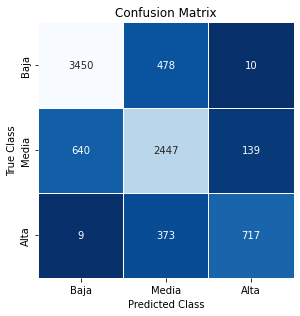

In [37]:
# graficamos la matriz de confusion

plt.figure(figsize=(4.5,4.5))
sns.heatmap(df_mc, annot=True, linewidths=.5, fmt=".0f", square = True, cmap = 'Blues_r', cbar=None ).set(xlabel='Predicted Class', ylabel='True Class')
plt.title("Confusion Matrix"), plt.tight_layout()
plt.show()

In [51]:
# Calculamos Todas las metricas --> luego abra que justificar cuales son las mas relevantes
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, roc_auc_score

B = 0.5

# comparan los resultados (y1_test) con los valores reales (y1_pred)
m1 = accuracy_score(y1_test,y1_pred)

m2 = precision_score(y1_test,y1_pred, average='micro')

m3 = recall_score(y1_test,y1_pred, average='micro')

m4 = f1_score(y1_test,y1_pred, average='micro')

m5 = fbeta_score(y1_test,y1_pred,beta= B, average='micro')

m6 = roc_auc_score(y1_test,y1_pred)

print('accuracy:{}'.format(m1.round(3)))
print('precision:{}'.format(m2.round(3)))
print('recall:{}'.format(m3.round(3)))
print('f1-score:{}'.format(m4.round(3)))
print('fbeta-score:{}'.format(m5.round(3)))
print('roc-auc:{}'.format(m6.round(3)))

accuracy:0.8
precision:0.8
recall:0.8
f1-score:0.8
fbeta-score:0.8
roc-auc:0.825


In [ ]:
# Vemos los resultados parciales de cada clase para cada metrica
from sklearn.metrics import classification_report

nombres = ['Baja', 'Media', 'Alta']
print(classification_report(y1_test.argmax(axis=1), y1_pred.argmax(axis=1), target_names = nombres))

              precision    recall  f1-score   support

        Baja       0.91      0.91      0.91      3938
       Media       0.85      0.85      0.85      3226
        Alta       0.87      0.88      0.88      1099

    accuracy                           0.88      8263
   macro avg       0.88      0.88      0.88      8263
weighted avg       0.88      0.88      0.88      8263



In [75]:
pd.DataFrame(dic)

,precision,recall,fbeta-score,support
0,0.841669,0.876079,0.848333,3938
1,0.741965,0.758524,0.745219,3226
2,0.827945,0.652411,0.785667,1099


In [ ]:
dat['Clase'] = dat[i,'Clase'] for i in nombres.keys()

dat.set_index('Clase', inplace=True)

dat.to_latex()

In [81]:
from sklearn.metrics import precision_recall_fscore_support

mt = precision_recall_fscore_support(y1_test.argmax(axis=1), y1_pred.argmax(axis=1), beta = B)

dic = {'precision':mt[0], 'recall':mt[1], 'fbeta-score':mt[2], 'support':mt[3]}

dat = pd.DataFrame(dic)

dat['Clase'] = ['Baja', 'Media', 'Alta']

dat.set_index('Clase', inplace=True)

dat

,precision,recall,fbeta-score,support
Clase,,,,
Baja,0.841669,0.876079,0.848333,3938
Media,0.741965,0.758524,0.745219,3226
Alta,0.827945,0.652411,0.785667,1099


faltaria aca justificar la eleccion de las metricas, que puede tener dos variantes:

1) Tecnica: sabiendo si son para variables categoricas y multicases, y si sirven para casos desbalanceados o no.
y que muestra c/u:
La curva P-R (precision-recall): solo puede usarse en problemas de clasificacion binaria --> NO es posible utilizarse en casos de varias clases y ademas no funciona bien cuando los datos estan desbalanceados (ver: https://programmerclick.com/article/1635848150/)
El accuracy tambien da un valor sesgado por su forma de calculo en casos desbalanceados.

En cambio la curva ROC es estable con casos desbalanceados y es posible usarse para casos de varias clases como el nuestro.
(recall y especificity)

es necesario igual buscar y leer un poco mas para poder justificar bien tecnicamente. Habria que repasar el material, para ver que se llego a ver de c/u.

--- Filas:  Valores Reales // Columnas: Valores Predichos ---

precision (diagonal / Columna): del total que predice como B,M,A cuantos relamente lo son = al mercado tambien los valua como B,M,A. 

recall (diagonal / Fila): del total que realmente son B,M,A (ó en ese valor estan en mercado), cuantos logra clasificar igual o detectar como tal.

especificity (diagonal / Filas ): del total que 

### Graficamos el Arbol Simple generado (punto 6)

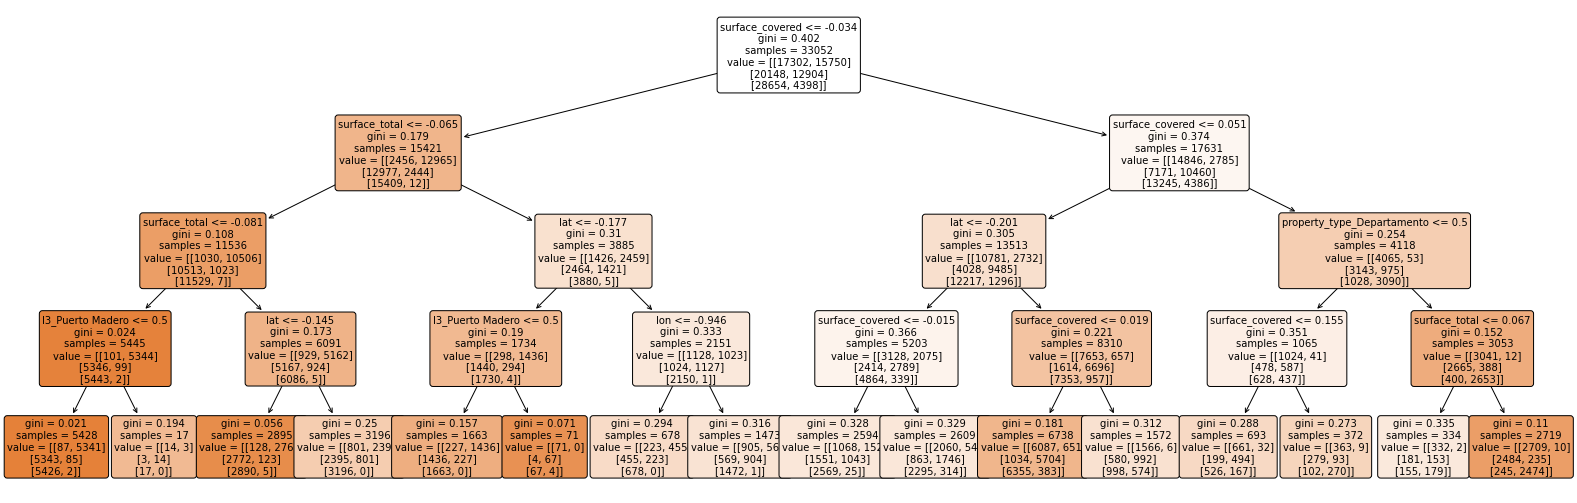

In [49]:
from sklearn.tree import plot_tree

etiquetas = x1_train.columns

plt.figure(figsize=(28,9))
plot_tree(arbol_simple, feature_names = etiquetas, max_depth = max_depth, filled=True,proportion=False, rounded=True, class_names=nombres, fontsize=10);

### Variables de mayor importancia en el modelo del Arbol Simle (punto 7)

Analisis del grafico presendente:
Vemos en el grafico del arbol que la variable mas importante es la superficie cubierta (surface_covered), que es el primer atributo por el que divide, seguido por la superfice total (suface_total) como segundo factor de relevancia. Con lo cual podemos entender que la superficie la variable que mas define el valor de una propiedad.

Luego esta seguido por la latitud(lat) y si el tipo de propiedad es departamento (property_type_Departamento)

1) surface_covered
2) surface_total
3) lat
4) property_type_Departamento


In [82]:
# Analizamos la relevancia de cada variable mediante el calculo de la importancia de atributos:

b = pd.DataFrame(arbol_simple.feature_importances_)
a = pd.DataFrame(arbol_simple.feature_names_in_)
resume = pd.concat([a,b],axis=1)
resume = resume.set_axis(['name_features','importance'],axis=1)
resume.sort_values('importance', ascending=False, inplace=False)

,name_features,importance
6,surface_covered,0.806445
0,lat,0.087604
5,surface_total,0.059086
64,property_type_Departamento,0.028851
40,l3_Puerto Madero,0.010966
...,...,...
30,l3_Nuñez,0.000000
31,l3_Once,0.000000
32,l3_Palermo,0.000000
33,l3_Parque Avellaneda,0.000000


Mediante el calculo del feature_importance, la superficie cubierta (surface_covered) se mantiene como la variable mas importante del modelo, con un amplia diferencia sobre todas las las demas, representando mas del 80% de la significatividad total del modelo.

Solo intercambian posiciones la superficie total y la latitud, pasando la primera al tercer puesto y la latitud escalando como la de segunda importancia. 
Pero se mantienen las mismas 4 variables como las de mayor relevancia. 

La interpretacion el logica, puesto que lo que mas importaria seria:
1) Superficie cubierta: las propiedades suelen tener un precio por m2, y si varia la cantidad de m2 construidos, varia el precio de la propiedad linealmente.

2) latitud: indica si esta al sur o norte, un indicador clave por la diferencia economica exitente entre ambas zonas en la ciudad de buenos aires

3) tipo de propiedad: si es Departamento es algo importante para valuar, puesto que es el tipo de inmueble mas demando y frecuente en una ciudad de alta concentracion poblacional como es CABA, diferenciandose del resto de tipos de inmuebles.

4) si esta en Puerto Madero: puesto que es un barrio de caracteristicas que hacen sus valuaciones muy diferentes al resto de la ciudad

### 5-fold Cross Validation

In [ ]:
seed = 13
X_train, x_test, Y_train, y_test = train_test_split(X.iloc[:,1:-1],labels, test_size=0.3, random_state=seed)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

model = DecisionTreeClassifier(random_state=seed)

param_grid = {
    'criterion': ['gini', 'entropy'],  #2
    'min_samples_leaf': np.linspace(0.0001,0.1,100), #100
    'max_depth': list(range(4,31))#26
}



opt = RandomizedSearchCV(
    model,
    param_distributions = param_grid,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    n_iter=100,
    error_score="raise",
    return_train_score=True
    )

opt.fit(X_train, Y_train)

print('Best params achieve a test score of', opt.score(x_test, y_test), ':')

params = dict(opt.best_params_)

from datetime import datetime
hoy = datetime.now().strftime("%Y%m%d%H%M")
 
cv_results = pd.DataFrame(opt.cv_results_)
cv_results.to_csv(f"./resultados/cv_results-{hoy}.csv", index=False)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best params achieve a test score of 0.9552972141482963 :


### Mejor Modelo en CV

In [ ]:
cv_results2 = cv_results[['params','mean_test_score','std_test_score', 
                       'mean_train_score', 'std_train_score']].sort_values('mean_test_score')

In [ ]:
idx = cv_results2.mean_train_score.idxmax()
train_score = cv_results2.mean_train_score.to_list()
train_score[idx] = mean([train_score[idx-1], train_score[idx+1])

67

In [ ]:
np.max(train_score)

0.9972887978735294

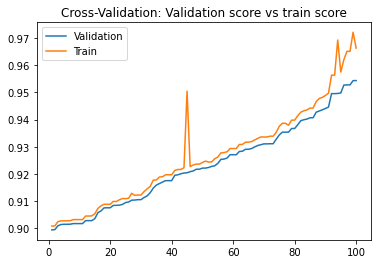

In [ ]:
#corrijo un valor raro
idx = cv_results2.mean_train_score.idxmax()
cv_results2.loc[idx, "mean_train_score"] = (cv_results2.mean_train_score[idx-1] + cv_results2.mean_train_score[idx+1])/2

plt.plot(range(1,len(cv_results2.mean_test_score)+1), cv_results2.mean_test_score, label="Validation")
plt.plot(range(1,len(cv_results2.mean_train_score)+1), cv_results2.mean_train_score, label= "Train")
plt.legend()
plt.title("Cross-Validation: Validation score vs train score")
plt.show()
#plt.savefig("./img/CV.png", dpi=200, facecolor="white")

In [ ]:
params = dict(opt.best_params_)

clf = DecisionTreeClassifier(random_state=seed, **params)
#clf = DecisionTreeClassifier(random_state=seed)
clf.fit(X_train, Y_train)
preds = clf.predict(x_test)

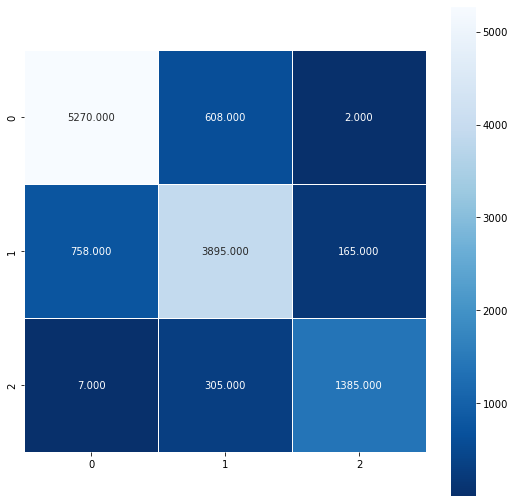

In [ ]:
cm = confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1))
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_test.argmax(axis=1), preds.argmax(axis=1), target_names = target_names))

              precision    recall  f1-score   support

     class 0       0.87      0.90      0.88      5880
     class 1       0.81      0.81      0.81      4818
     class 2       0.89      0.82      0.85      1697

    accuracy                           0.85     12395
   macro avg       0.86      0.84      0.85     12395
weighted avg       0.85      0.85      0.85     12395

